In [2]:
# 할당된 GPU 보기
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3965136641125189705
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15760099424778582115
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
# 현재 할당된 것이 CPU인지 GPU인지 확인
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 할당된 GPU를 실행
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus :
  try :
    # GPU 메모리 사용을 설|정
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as re :  
    print(re)

In [5]:
# GPU 메모리를 전부 할당하지 않고 필요에 따라 자동으로 할당하도록 설정
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

# 패션데이터셋을 이용한 이미지 분류

- 패션 데이터셋
  - 10가지의 패션 이미지 데이터로 구성
  - 60000개의 데이터
  - 이미지 크기 : 28 x 28
  
- Xception 모델을 전이학습

In [6]:
# 데이터 로드
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
# 훈련데이터 1000개, 테스트데이터 300개만 사용
X_train = X_train[:1000, :]
y_train = y_train[:1000]
X_test = X_test[:300, :]
y_test = y_test[:300]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 28, 28), (1000,), (300, 28, 28), (300,))

In [8]:
# y의 라벨 확인
import pandas as pd

print(pd.Series(y_train).unique())
print(pd.Series(y_test).unique())

[9 0 3 2 7 5 1 6 4 8]
[9 2 1 6 4 5 7 3 8 0]


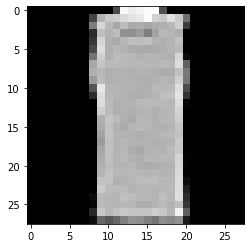

In [9]:
# 이미지 확인
import matplotlib.pyplot as plt

plt.imshow(X_train[160], cmap="gray")

In [10]:
# y를 원핫 인코딩
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((1000, 10), (300, 10))

In [11]:
# 이미지를 (244, 244) 크기로 변환
from PIL import Image
import numpy as np

train_resize_list = []
for i in range(len(X_train)) :
  train_resize_img = Image.fromarray(X_train[i]).resize((244, 244))
  train_resize_list.append(np.array(train_resize_img))

test_resize_list = []
for i in range(len(X_test)) :
  test_resize_img = Image.fromarray(X_test[i]).resize((244, 244))
  test_resize_list.append(np.array(test_resize_img))

In [12]:
X_train_resized = np.array(train_resize_list)
X_test_resized = np.array(test_resize_list)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244), (300, 244, 244))

In [13]:
# 색상채널 차원 추가
X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], 244, 244, 1)
X_test_resized = X_test_resized.reshape(X_test_resized.shape[0], 244, 244, 1)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

In [15]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model1 = Sequential()

# CNN 층 설계 - 특성 추출기
# CNN 층의 최종 크기는 10x10보다 크거나 작거나
model1.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(244, 244, 1), activation="relu"))
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 다차원 데이터를 1차원을 변환
model1.add(Flatten())

# 분류기 모델 설계
model1.add(Dense(units=256, activation="relu"))
model1.add(Dense(units=64, activation="relu"))
model1.add(Dense(units=10, activation="softmax"))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 242, 242, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 116, 116, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 128)      0         
 2D)                                                  

In [16]:
model1.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [17]:
h1 = model1.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 17s 131ms/step - loss: 55.1625 - accuracy: 0.6260 - val_loss: 0.8240 - val_accuracy: 0.7367
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 0.3569 - accuracy: 0.8800 - val_loss: 0.6363 - val_accuracy: 0.8133
Epoch 3/10
50/50 [==============================] - 6s 126ms/step - loss: 0.1497 - accuracy: 0.9450 - val_loss: 0.8121 - val_accuracy: 0.7633
Epoch 4/10
50/50 [==============================] - 6s 127ms/step - loss: 0.0858 - accuracy: 0.9720 - val_loss: 0.9037 - val_accuracy: 0.7833
Epoch 5/10
50/50 [==============================] - 6s 122ms/step - loss: 0.0957 - accuracy: 0.9660 - val_loss: 1.1108 - val_accuracy: 0.7833
Epoch 6/10
50/50 [==============================] - 6s 121ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 1.0671 - val_accuracy: 0.8067
Epoch 7/10
50/50 [==============================] - 6s 121ms/step - loss: 0.0402 - accuracy: 0.9890 - val_loss: 1.0464 - val_accuracy: 0.8033
Epoc

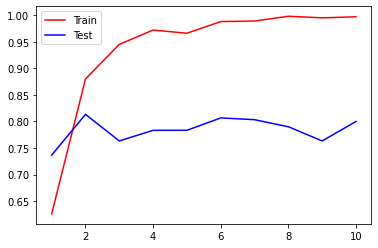

In [19]:
import matplotlib.pyplot as plt

acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()

# Dropout을 이용한 과적합 방지

- Dropout 
   - 각 층의 퍼셉스톤의 수를 줄여서 과적합을 방지
   - 0.5이하의 값을 사용
   - 이전층과 다음층의 파라미터의 수가 많이 차이나는 곳에 배치

In [22]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout

model2 = Sequential()

# CNN 층 설계 - 특성 추출기
# CNN 층의 최종 크기는 10x10보다 크거나 작거나
model2.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(244, 244, 1), activation="relu"))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

# 다차원 데이터를 1차원을 변환
model2.add(Flatten())

# 분류기 모델 설계
model2.add(Dense(units=256, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(units=64, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=10, activation="softmax"))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 242, 242, 32)      320       
                                                                 
 conv2d_17 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 118, 118, 64)      18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 116, 116, 128)     73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 58, 58, 128)      0         
 2D)                                                  

In [23]:
model2.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [24]:
h2 = model2.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 7s 130ms/step - loss: 17.2245 - accuracy: 0.4720 - val_loss: 0.9988 - val_accuracy: 0.7367
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 0.9226 - accuracy: 0.7430 - val_loss: 0.7587 - val_accuracy: 0.7967
Epoch 3/10
50/50 [==============================] - 6s 125ms/step - loss: 0.5913 - accuracy: 0.8010 - val_loss: 0.6627 - val_accuracy: 0.7800
Epoch 4/10
50/50 [==============================] - 6s 127ms/step - loss: 0.5104 - accuracy: 0.8300 - val_loss: 0.6477 - val_accuracy: 0.7933
Epoch 5/10
50/50 [==============================] - 6s 127ms/step - loss: 0.4298 - accuracy: 0.8680 - val_loss: 0.7111 - val_accuracy: 0.8000
Epoch 6/10
50/50 [==============================] - 6s 125ms/step - loss: 0.2909 - accuracy: 0.8990 - val_loss: 0.5353 - val_accuracy: 0.8500
Epoch 7/10
50/50 [==============================] - 6s 127ms/step - loss: 0.2790 - accuracy: 0.9230 - val_loss: 0.6643 - val_accuracy: 0.8100
Epoch

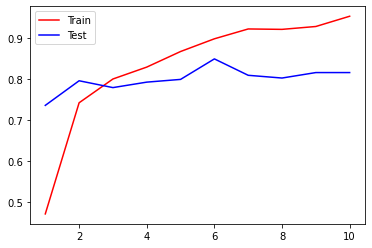

In [25]:
import matplotlib.pyplot as plt

acc = h2.history["accuracy"]
val_acc = h2.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()

# BatchNormalization을 이용한 과적합 방지

- CNN 층에서 w, b의 값들을 정규화 (일정한 범위의 값으로 변환)
- 결과값의 변동폭을 줄여주는 효과

- Conv 층과 Activation 층 사이에 배치
  - Activation 층에 다음에 오면 Activation 층이 약간 정규화하는 효과가 있기 때문에 효과가 떨어짐

In [40]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation

model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(244, 244, 1)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(filters=32, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=64, kernel_size=(3, 3)))
model3.add(Activation("relu"))
model3.add(Conv2D(filters=128, kernel_size=(3, 3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))

# 다차원 데이터를 1차원을 변환
model3.add(Flatten())

# 분류기 모델 설계
model3.add(Dense(units=256, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(units=64, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=10, activation="softmax"))

model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 242, 242, 32)      320       
                                                                 
 batch_normalization_9 (Batc  (None, 242, 242, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_20 (Activation)  (None, 242, 242, 32)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 batch_normalization_10 (Bat  (None, 240, 240, 32)     128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 240, 240, 32)    

In [42]:
model3.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [43]:
h3 = model3.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 8s 130ms/step - loss: 5.0024 - accuracy: 0.4520 - val_loss: 1.1922 - val_accuracy: 0.7133
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 0.8554 - accuracy: 0.7200 - val_loss: 1.0178 - val_accuracy: 0.7267
Epoch 3/10
50/50 [==============================] - 6s 130ms/step - loss: 0.6315 - accuracy: 0.7920 - val_loss: 0.6488 - val_accuracy: 0.8000
Epoch 4/10
50/50 [==============================] - 6s 127ms/step - loss: 0.5073 - accuracy: 0.8330 - val_loss: 0.5781 - val_accuracy: 0.8000
Epoch 5/10
50/50 [==============================] - 6s 130ms/step - loss: 0.3935 - accuracy: 0.8650 - val_loss: 0.5415 - val_accuracy: 0.8333
Epoch 6/10
50/50 [==============================] - 6s 128ms/step - loss: 0.3242 - accuracy: 0.8840 - val_loss: 0.5553 - val_accuracy: 0.8167
Epoch 7/10
50/50 [==============================] - 6s 128ms/step - loss: 0.2900 - accuracy: 0.9050 - val_loss: 0.6331 - val_accuracy: 0.8133
Epoch 

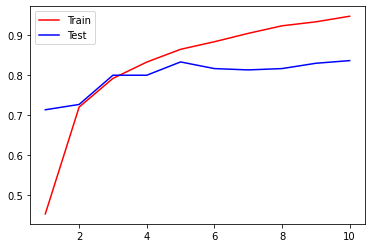

In [44]:
import matplotlib.pyplot as plt

acc = h3.history["accuracy"]
val_acc = h3.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()

# GlobalAveragePooling2D을 이용한 과적합 방지 

- Flatten() 층 대신에 사용
- 다차원 배열을 1차원 만들때 AveragePooling 방법을 사용
- 근처 특성값들을 평균내서 크기를 줄이는 방식으로 1차원으로 변환

In [51]:
# w, b를 초기값을 동일하게 하기 위해서 seed 설정 필요
import tensorflow as tf
import numpy as np

seed = 0

np.random.seed(seed)
tf.random.set_seed(seed)

In [47]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation

model4 = Sequential()

model4.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(244, 244, 1)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(Conv2D(filters=32, kernel_size=(3, 3)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(filters=64, kernel_size=(3, 3)))
model4.add(Activation("relu"))
model4.add(Conv2D(filters=128, kernel_size=(3, 3)))
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))

# 다차원 데이터를 1차원을 변환
model4.add(GlobalAveragePooling2D())

# 분류기 모델 설계
model4.add(Dense(units=256, activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(units=64, activation="relu"))
model4.add(Dropout(0.2))
model4.add(Dense(units=10, activation="softmax"))

model4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 242, 242, 32)      320       
                                                                 
 batch_normalization_15 (Bat  (None, 242, 242, 32)     128       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 242, 242, 32)      0         
                                                                 
 conv2d_53 (Conv2D)          (None, 240, 240, 32)      9248      
                                                                 
 batch_normalization_16 (Bat  (None, 240, 240, 32)     128       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 240, 240, 32)    

In [48]:
model4.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [49]:
h4 = model4.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 7s 109ms/step - loss: 2.3078 - accuracy: 0.1060 - val_loss: 2.2765 - val_accuracy: 0.1267
Epoch 2/10
50/50 [==============================] - 5s 105ms/step - loss: 2.2505 - accuracy: 0.1270 - val_loss: 2.2195 - val_accuracy: 0.1133
Epoch 3/10
50/50 [==============================] - 5s 105ms/step - loss: 2.0918 - accuracy: 0.2340 - val_loss: 2.0382 - val_accuracy: 0.1933
Epoch 4/10
50/50 [==============================] - 5s 105ms/step - loss: 1.8626 - accuracy: 0.2780 - val_loss: 2.4026 - val_accuracy: 0.1700
Epoch 5/10
50/50 [==============================] - 5s 105ms/step - loss: 1.6221 - accuracy: 0.3350 - val_loss: 2.6609 - val_accuracy: 0.2000
Epoch 6/10
50/50 [==============================] - 5s 101ms/step - loss: 1.4733 - accuracy: 0.3910 - val_loss: 1.7496 - val_accuracy: 0.3800
Epoch 7/10
50/50 [==============================] - 5s 105ms/step - loss: 1.4344 - accuracy: 0.3950 - val_loss: 1.2498 - val_accuracy: 0.5267
Epoch 

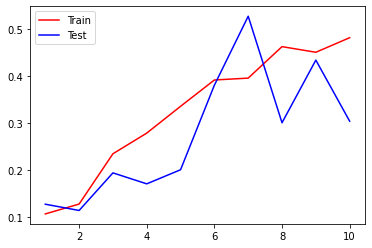

In [61]:
import matplotlib.pyplot as plt

acc = h4.history["accuracy"]
val_acc = h4.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()

# Xception 모델을 이용한 전이학습

In [ ]:
# Exception 모델 가져오기
from tensorflow.keras.applications import Xception

# include_top : 모델을 가져올때 분류기를 가져올지 여부 (False이면 CNN층만 가져옴)
# weights : 가져올 가중치의 종류 (imagenet)
# input_shape() : 사용할 입력이미지 크기
pre_trained_model = Xception(include_top = False,
                             weights = "imagenet",
                             input_shape = (244, 244, 3))

pre_trained_model.summary()

In [55]:
X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

In [56]:
# 1채널인 색상채널을 3채널로 변환
# 3차원 축을 3번 반복해서 저장
X_train_resized = np.repeat(X_train_resized, 3, axis=3)
X_test_resized = np.repeat(X_test_resized, 3, axis=3)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 3), (300, 244, 244, 3))

In [58]:
# 전이학습 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model5 = Sequential()

# Xception 모델을 전이학습
model5.add(pre_trained_model)

model5.add(Flatten())

# 우리가 설계한 분류 모델을 추가
model5.add(Dense(units=512, activation="relu"))
model5.add(Dense(units=10, activation="softmax"))

model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_12 (Flatten)        (None, 131072)            0         
                                                                 
 dense_42 (Dense)            (None, 512)               67109376  
                                                                 
 dense_43 (Dense)            (None, 10)                5130      
                                                                 
Total params: 87,975,986
Trainable params: 87,921,458
Non-trainable params: 54,528
_________________________________________________________________


In [59]:
model5.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [60]:
h5 = model5.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10
50/50 [==============================] - 30s 473ms/step - loss: 2.5260 - accuracy: 0.3430 - val_loss: 1.5715 - val_accuracy: 0.4900
Epoch 2/10
50/50 [==============================] - 23s 453ms/step - loss: 0.9432 - accuracy: 0.6690 - val_loss: 1.0448 - val_accuracy: 0.6967
Epoch 3/10
50/50 [==============================] - 23s 459ms/step - loss: 0.5503 - accuracy: 0.8230 - val_loss: 0.8403 - val_accuracy: 0.7567
Epoch 4/10
50/50 [==============================] - 24s 491ms/step - loss: 0.4862 - accuracy: 0.8490 - val_loss: 1.9817 - val_accuracy: 0.6567
Epoch 5/10
50/50 [==============================] - 25s 496ms/step - loss: 0.3370 - accuracy: 0.9040 - val_loss: 0.6756 - val_accuracy: 0.8267
Epoch 6/10
50/50 [==============================] - 25s 497ms/step - loss: 0.2541 - accuracy: 0.9190 - val_loss: 1.7654 - val_accuracy: 0.7433
Epoch 7/10
50/50 [==============================] - 25s 501ms/step - loss: 0.1702 - accuracy: 0.9470 - val_loss: 0.5901 - val_accuracy: 0.8067

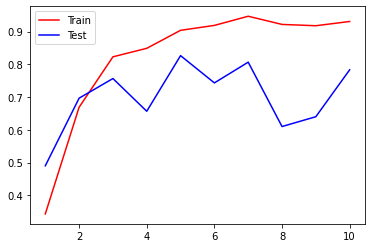

In [62]:
import matplotlib.pyplot as plt

acc = h5.history["accuracy"]
val_acc = h5.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()